C:\Users\derej\Desktop\Kifya\changepoint_analysis\src\data_processing\load_data.py:5: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)
C:\Users\derej\Desktop\Kifya\changepoint_analysis\src\data_processing\load_data.py:12: UserWarning: Parsing dates in %m/%d/%Y format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df['Date'] = pd.to_datetime(df['Date'], dayfirst=True)


Data loaded and preprocessed successfully.


,Date,Price,log_return
1,1987-05-21,18.45,-0.009709
2,1987-05-22,18.55,0.005405
3,1987-05-25,18.60,0.002692
4,1987-05-26,18.63,0.001612
5,1987-05-27,18.60,-0.001612


,Date,ShockType,LogReturn,Event_Description,Category
0,1987-12-22,Positive Shock,0.081041,Statistically detected structural shock,Market Shock
1,1988-11-25,Positive Shock,0.124438,Statistically detected structural shock,Market Shock
2,1990-10-22,Negative Shock,-0.190184,Statistically detected structural shock,Market Shock
3,1991-01-17,Negative Shock,-0.361214,Statistically detected structural shock,Market Shock
4,1998-03-23,Positive Shock,0.162559,Statistically detected structural shock,Market Shock


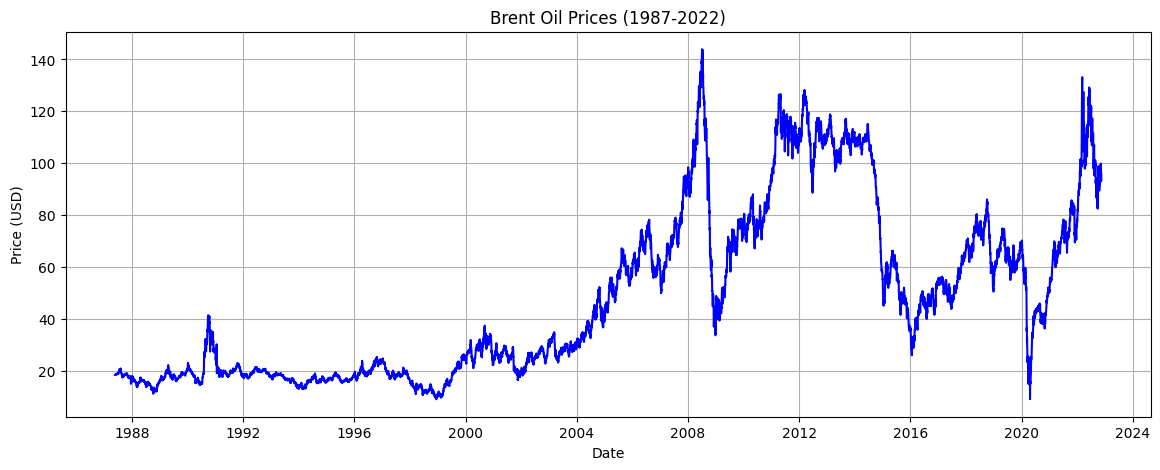

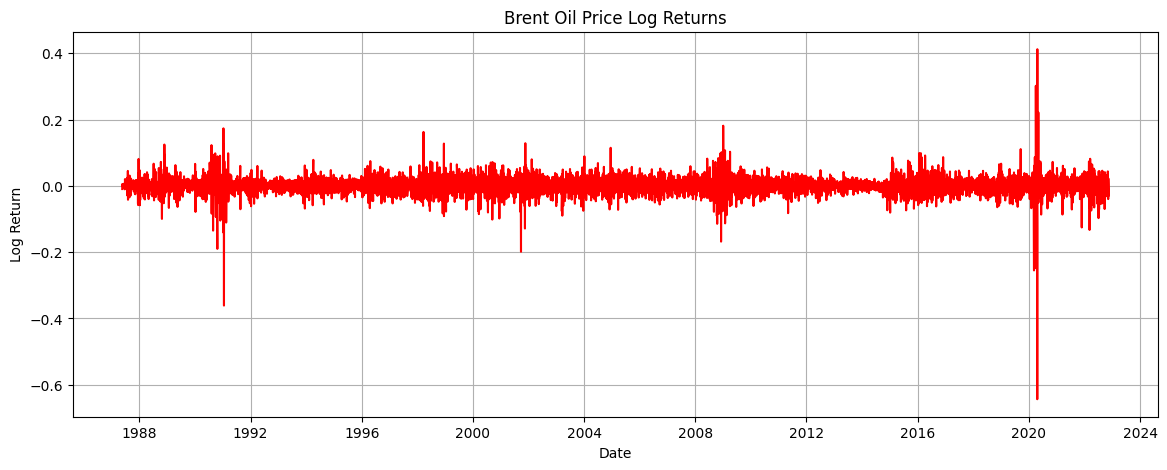

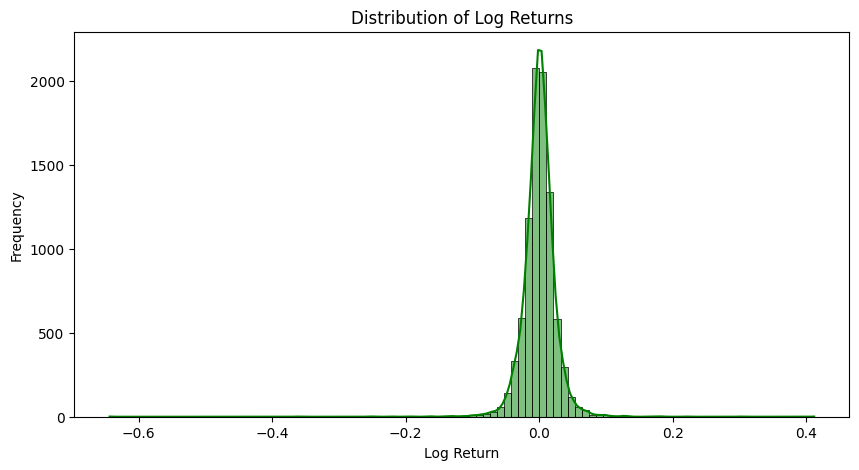

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Metropolis: [tau]
>NUTS: [mu1, mu2, sigma]


Output()

In [ ]:
# ==========================================================
# Task 2: Bayesian Change Point Analysis for Brent Oil Prices
# ==========================================================

# -----------------------------
# Imports
# -----------------------------
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc as pm
import arviz as az
import importlib

# Add project root to sys.path for src imports
project_root = Path().resolve().parent  # notebook is in 'notebooks/'
sys.path.append(str(project_root))

# Import custom modules
import src.data_processing.load_data as ld
import src.data_processing.preprocess as pp
import src.modelling.analysis_utils as au
import src.modelling.bayesian_cp_model as bcm
importlib.reload(ld)
importlib.reload(pp)
importlib.reload(au)
importlib.reload(bcm)

from src.data_processing.load_data import load_brent_prices, load_detected_events
from src.data_processing.preprocess import compute_log_returns
from src.modelling.analysis_utils import (
    get_change_point,
    plot_price_with_change_point,
    associate_events,
    quantify_impact,
    summarize_change_points
)
from src.modelling.bayesian_cp_model import bayesian_change_point_model, plot_trace, plot_change_point_distribution

# -----------------------------
# Step 1: Load & Preprocess Data
# -----------------------------
try:
    prices_df = load_brent_prices(project_root / "data/raw/BrentOilPrices.csv")
    events_df = load_detected_events(project_root / "data/processed/detected_events.csv")
    prices_df = compute_log_returns(prices_df)
except FileNotFoundError as e:
    print(f"File not found: {e}")
except Exception as e:
    print(f"Error loading or preprocessing data: {e}")
else:
    print("Data loaded and preprocessed successfully.")
    display(prices_df.head())
    display(events_df.head())

# -----------------------------
# Step 2: Exploratory Data Analysis
# -----------------------------
def plot_price_series(prices_df):
    plt.figure(figsize=(14,5))
    plt.plot(prices_df['Date'], prices_df['Price'], color='blue')
    plt.title('Brent Oil Prices (1987-2022)')
    plt.xlabel('Date')
    plt.ylabel('Price (USD)')
    plt.grid(True)
    plt.show()

def plot_log_returns(prices_df):
    plt.figure(figsize=(14,5))
    plt.plot(prices_df['Date'], prices_df['log_return'], color='red')
    plt.title('Brent Oil Price Log Returns')
    plt.xlabel('Date')
    plt.ylabel('Log Return')
    plt.grid(True)
    plt.show()

def plot_log_return_hist(prices_df):
    plt.figure(figsize=(10,5))
    sns.histplot(prices_df['log_return'], bins=100, kde=True, color='green')
    plt.title('Distribution of Log Returns')
    plt.xlabel('Log Return')
    plt.ylabel('Frequency')
    plt.show()

# Execute EDA plots
plot_price_series(prices_df)
plot_log_returns(prices_df)
plot_log_return_hist(prices_df)

# -----------------------------
# Step 3: Bayesian Change Point Model
# -----------------------------
log_returns = prices_df['log_return'].values

try:
    trace, model = bayesian_change_point_model(log_returns)
except Exception as e:
    print(f"Error running Bayesian change point model: {e}")
else:
    print("Bayesian model completed successfully.")

# -----------------------------
# Step 4: Model Diagnostics & Posterior Visualization
# -----------------------------
try:
    plot_trace(trace)
    plot_change_point_distribution(trace, prices_df['Date'].values)
    summary_stats = az.summary(trace, round_to=4)
    display(summary_stats)
except Exception as e:
    print(f"Error during model diagnostics: {e}")

# -----------------------------
# Step 5: Extract Change Point & Quantify Impact
# -----------------------------
try:
    tau, tau_samples = get_change_point(trace)
    print(f"Most probable change point index: {tau}, Date: {prices_df['Date'].iloc[tau]}")
    
    plot_price_with_change_point(prices_df, tau)
    
    matched_events = associate_events(prices_df, events_df, tau, window_days=5)
    print("Events near the change point:")
    display(matched_events)
    
    impact = quantify_impact(prices_df, tau)
    print("Impact of Change Point on Prices:")
    print(f"Average before: ${impact['before_mean']:.2f}")
    print(f"Average after: ${impact['after_mean']:.2f}")
    print(f"Change: ${impact['change']:.2f} ({impact['percent_change']:.2f}%)")
except Exception as e:
    print(f"Error during change point analysis: {e}")

# -----------------------------
# Step 6: Summary Table of Detected Change Points
# -----------------------------
try:
    tau_list = [tau]  # extend with more change points if detected iteratively
    summary_table = summarize_change_points(prices_df, events_df, tau_list)
    print("Summary of Detected Change Points:")
    display(summary_table)
    
    # Optional: Save summary to CSV
    summary_table.to_csv(project_root / "data/processed/change_point_summary.csv", index=False)
except Exception as e:
    print(f"Error creating summary table: {e}")
